In [94]:
import json 


with open('data/real/change5-1.json') as f:
    data_1 = json.load(f)
    
with open('data/real/change5-2.json') as f:
    data_2 = json.load(f)

with open('data/real/change5-3.json') as f:
    data_3 = json.load(f)
    
    
data = data_1 + data_2 + data_3
data

[{'id': 104234072,
  'annotations': [{'id': 35248159,
    'completed_by': {'id': 21087,
     'email': 'rodda.matthew1@gmail.com',
     'first_name': 'Matthew',
     'last_name': 'Rodda'},
    'result': [{'id': 'q98qOR1_ks',
      'type': 'ellipselabels',
      'value': {'x': 63.63138808612664,
       'y': 52.68318575669297,
       'radiusX': 2.3456325470083454,
       'radiusY': 0.9624824040174911,
       'rotation': 2.205249284016702,
       'ellipselabels': ['crater']},
      'origin': 'manual',
      'to_name': 'img',
      'from_name': 'tag',
      'image_rotation': 0,
      'original_width': 2352,
      'original_height': 1728},
     {'id': 'UACCiJoUxR',
      'type': 'ellipselabels',
      'value': {'x': 72.4684423168836,
       'y': 47.870587473621065,
       'radiusX': 1.1282197322510457,
       'radiusY': 0.39109019677781115,
       'rotation': 3.5035316447868468,
       'ellipselabels': ['crater']},
      'origin': 'manual',
      'to_name': 'img',
      'from_name': 'tag',
 

In [117]:
labels = {}

factor_x = 2352/100
factor_y = 1728/100

for i in data:
    image_name = i['file_upload'].split('-')[1]
    ellipses = []
    
    
    if len(i['annotations']) == 0:
        continue
    
    for j in i['annotations'][0]['result']:
        ellipse = {}
        ellipse['x'] = j['value']['x']*factor_x
        ellipse['y'] = j['value']['y']*factor_y
        ellipse['semi_major'] = j['value']['radiusX']*factor_x
        ellipse['semi_minor'] = j['value']['radiusY']*factor_y
        ellipse['rotation'] = j['value']['rotation']
        
        ellipses.append(ellipse)
        
    labels[image_name] = ellipses
    


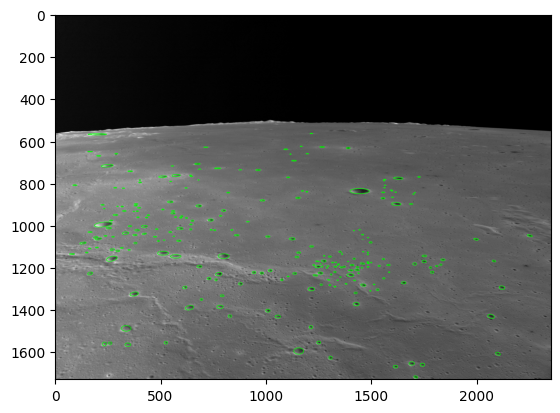

In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_name = '0.png'

ellipses = labels[image_name]

image = cv2.imread(f'data/real/ground_truth_images/{image_name}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for ellipse in ellipses:
    center = (int(ellipse['x']), int(ellipse['y']))
    axes = (int(ellipse['semi_major']), int(ellipse['semi_minor']))
    angle = ellipse['rotation']
    cv2.ellipse(image, center, axes, angle, 0, 360, (0, 255, 0), 2)
    
plt.imshow(image)
plt.show()

In [119]:
import os
import random
from cjm_torchvision_tfms.core import CustomRandomIoUCrop
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF
import cv2
from dataloader.SyntheticCratersDataset import SyntheticCratersDataset


In [120]:
image_dir = 'data/synthetic/ground_truth_images'
images_ellipses_dir = 'data/synthetic/ground_truth_projected_ellipses'

image_dir_items = [i.split(".")[0] for i in os.listdir(image_dir)]
images_ellipses_dir_items = [i.split(".")[0] for i in os.listdir(images_ellipses_dir)]
items = list(set(image_dir_items) & set(images_ellipses_dir_items))
items = sorted(items, key=lambda x: int(x.split('.')[0]))

images_name = [i+'.png' for i in items]
ellipses_name = [i+'.txt' for i in items]

img_dict = {i: os.path.join(image_dir, f'{item}.png') for i, item in enumerate(items)}

# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

In [121]:
train_sz = 1024

# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

    
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose([
    iou_crop,
    transforms.ColorJitter(
            brightness = (0.875, 1.125),
            contrast = (0.5, 1.5),
            saturation = (0.5, 1.5),
            hue = (-0.05, 0.05),
    ),
    transforms.RandomGrayscale(),
    transforms.RandomEqualize(),
    transforms.RandomPosterize(bits=3, p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

In [122]:
class_names = ['background']+['crater']

class_to_idx = {c: i for i, c in enumerate(class_names)}

train_dataset = SyntheticCratersDataset(train_keys, images_ellipses_dir, img_dict, class_to_idx, train_tfms)
valid_dataset = SyntheticCratersDataset(val_keys, images_ellipses_dir, img_dict, class_to_idx, valid_tfms)

In [123]:
image, target = train_dataset[0]

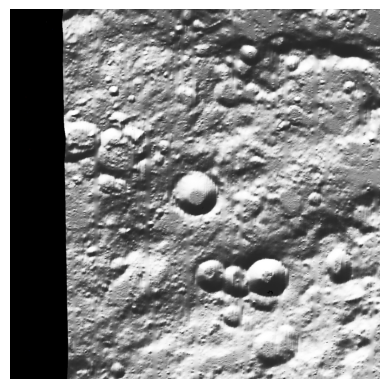

In [124]:
# Display the image and target
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()

/tmp/ipykernel_34631/74464110.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(image).transpose(1, 2, 0)


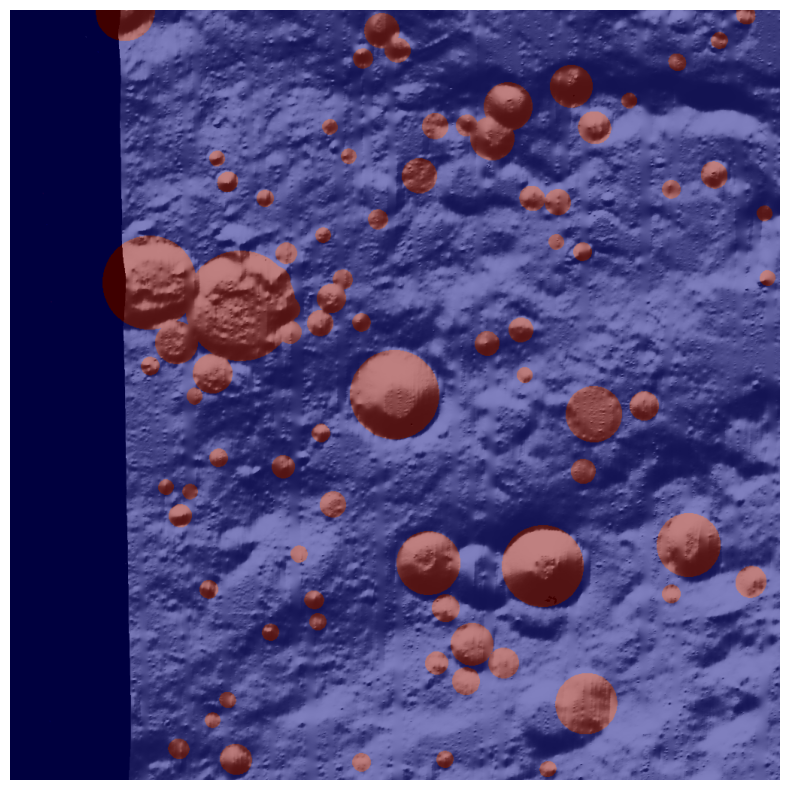

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming you have the `image` and `target` variables already loaded

# Get the masks from the target dictionary
masks = target["masks"]  # List of masks

# Convert the image to a numpy array (for display) and transpose it to (1024, 1024, 3)
image_np = np.array(image).transpose(1, 2, 0)

# Initialize a mask array with zeros, matching the size of the image
combined_mask = np.zeros(image_np.shape[:2], dtype=np.uint8)

# Combine all masks by adding them (ensure they are in the same shape as the image)
for mask in masks:
    # Convert mask to numpy if it is a Tensor
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Ensure the mask is binary (0 or 1)
    mask = np.array(mask, dtype=np.uint8)

    # Combine the mask with the overall mask (OR operation to accumulate the masks)
    combined_mask = np.maximum(combined_mask, mask)

# Visualize the image with overlaid combined masks
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_np)  # Show the original image
ax.imshow(combined_mask, cmap='jet', alpha=0.5)  # Overlay the combined mask with transparency
ax.axis('off')  # Hide axis
plt.show()


